In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 6000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TCS.NS'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                  open        high         low       close   Adj Close  \
Date                                                                     
2006-11-20  271.262512  280.250000  266.387512  279.462494  205.100784   
2006-11-21  279.049988  288.000000  278.500000  287.137512  210.733536   
2006-11-22  288.500000  292.750000  283.837494  287.024994  210.650848   
2006-11-23  289.000000  292.350006  285.000000  286.037506  209.926178   
2006-11-24  287.500000  289.225006  284.037506  287.500000  210.999451   

             volume  
Date                 
2006-11-20  5174936  
2006-11-21  4158152  
2006-11-22  5591464  
2006-11-23  3870324  
2006-11-24  3205304  
                   open         high          low        close    Adj Close  \
Date                                                                          
2023-04-17  3134.100098  3163.399902  3070.250000  3139.500000  3139.500000   
2023-04-18  3154.9499

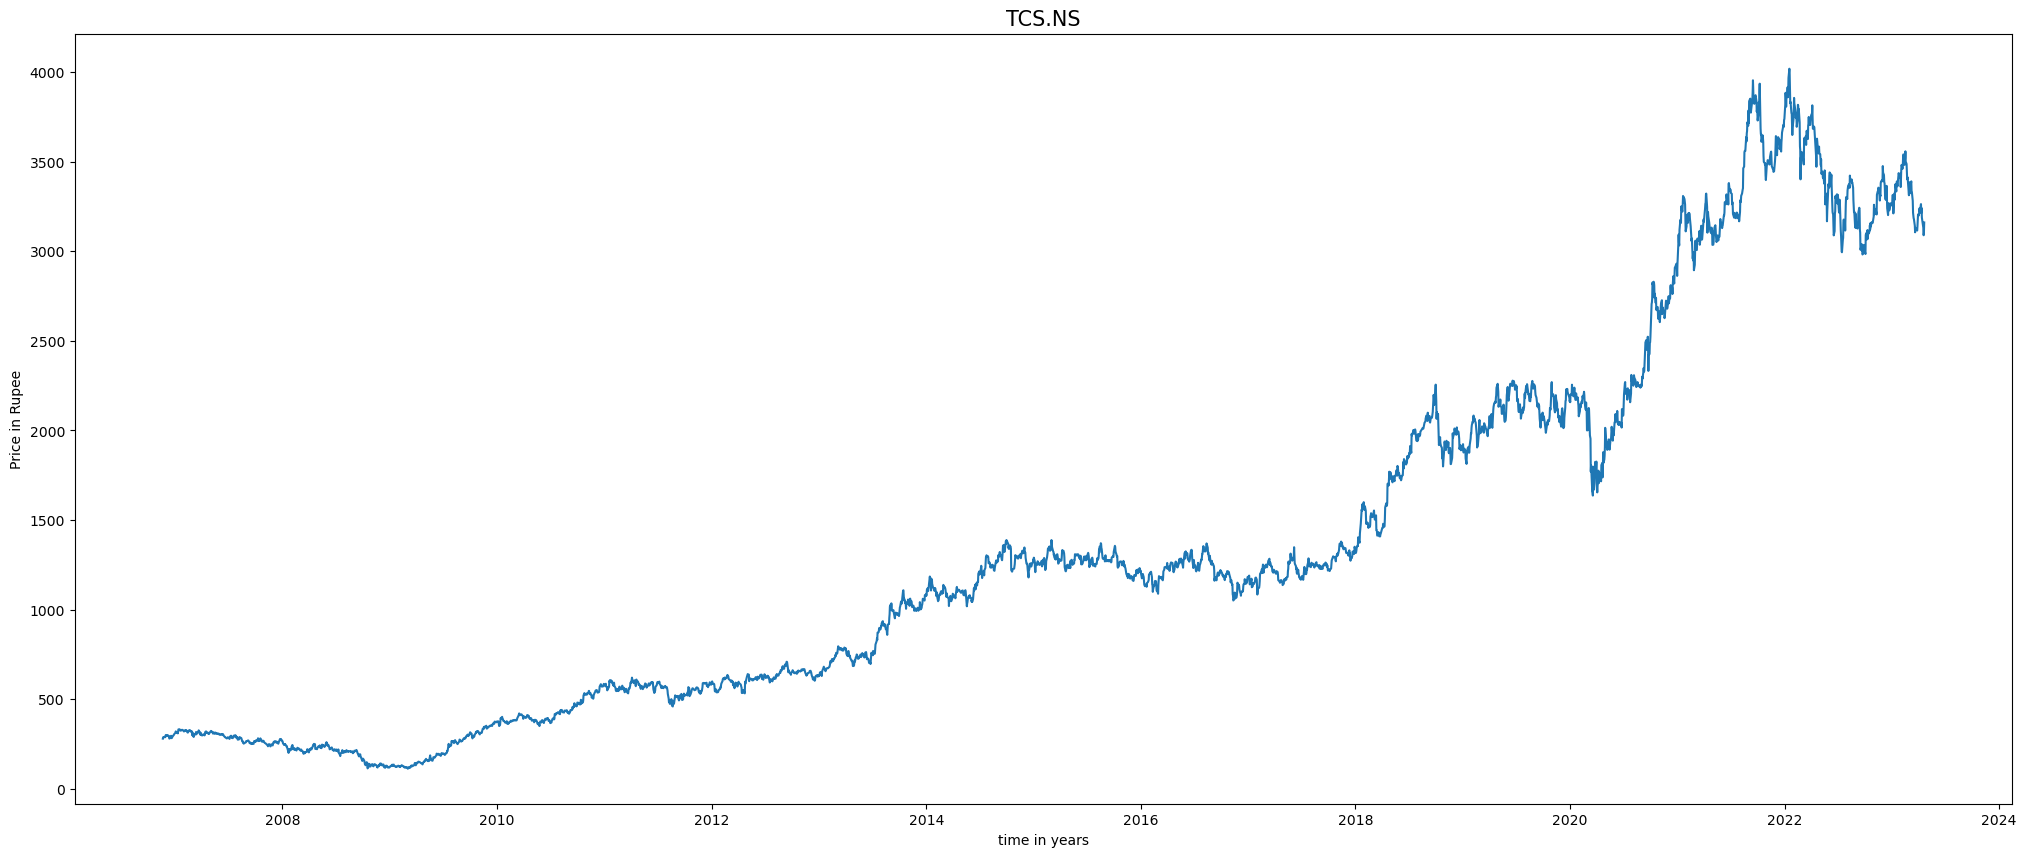

In [3]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
# data= pd.read_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file1.csv') reading stored csv when net not available
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
# data.to_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file1.csv')  # saving the dataframe
# print(len(data))
print(data.head())
print(data.tail())
plt.figure(figsize=(25,10))
plt.plot(data['close'])
plt.title(symbol,fontsize=15)
plt.ylabel('Price in Rupee')
plt.xlabel('time in years')                   # why is volume 0 on 2002-08-15 and still not showing in isnull()
plt.show()


In [ ]:
# remove where open =close or adj close

In [4]:
data.shape

(4049, 6)

In [5]:
data.describe()

,open,high,low,close,Adj Close,volume
count,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4.049000e+03
mean,1342.328491,1356.449754,1327.058249,1341.645190,1218.439778,3.268983e+06
std,1034.846852,1043.626137,1024.909674,1034.189485,1026.722344,2.801548e+06
min,112.000000,116.112503,103.837502,111.550003,84.846809,0.000000e+00
25%,524.000000,531.500000,515.150024,521.775024,413.774780,1.844590e+06
50%,1181.000000,1191.525024,1170.050049,1180.949951,1023.769043,2.599984e+06
75%,2005.000000,2022.000000,1983.300049,2004.449951,1834.253906,3.859712e+06
max,4033.949951,4043.000000,3980.000000,4019.149902,3885.789795,8.806715e+07


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2006-11-20 to 2023-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4049 non-null   float64
 1   high       4049 non-null   float64
 2   low        4049 non-null   float64
 3   close      4049 non-null   float64
 4   Adj Close  4049 non-null   float64
 5   volume     4049 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 221.4 KB


In [7]:
data.isnull().sum()

open         0
high         0
low          0
close        0
Adj Close    0
volume       0
dtype: int64

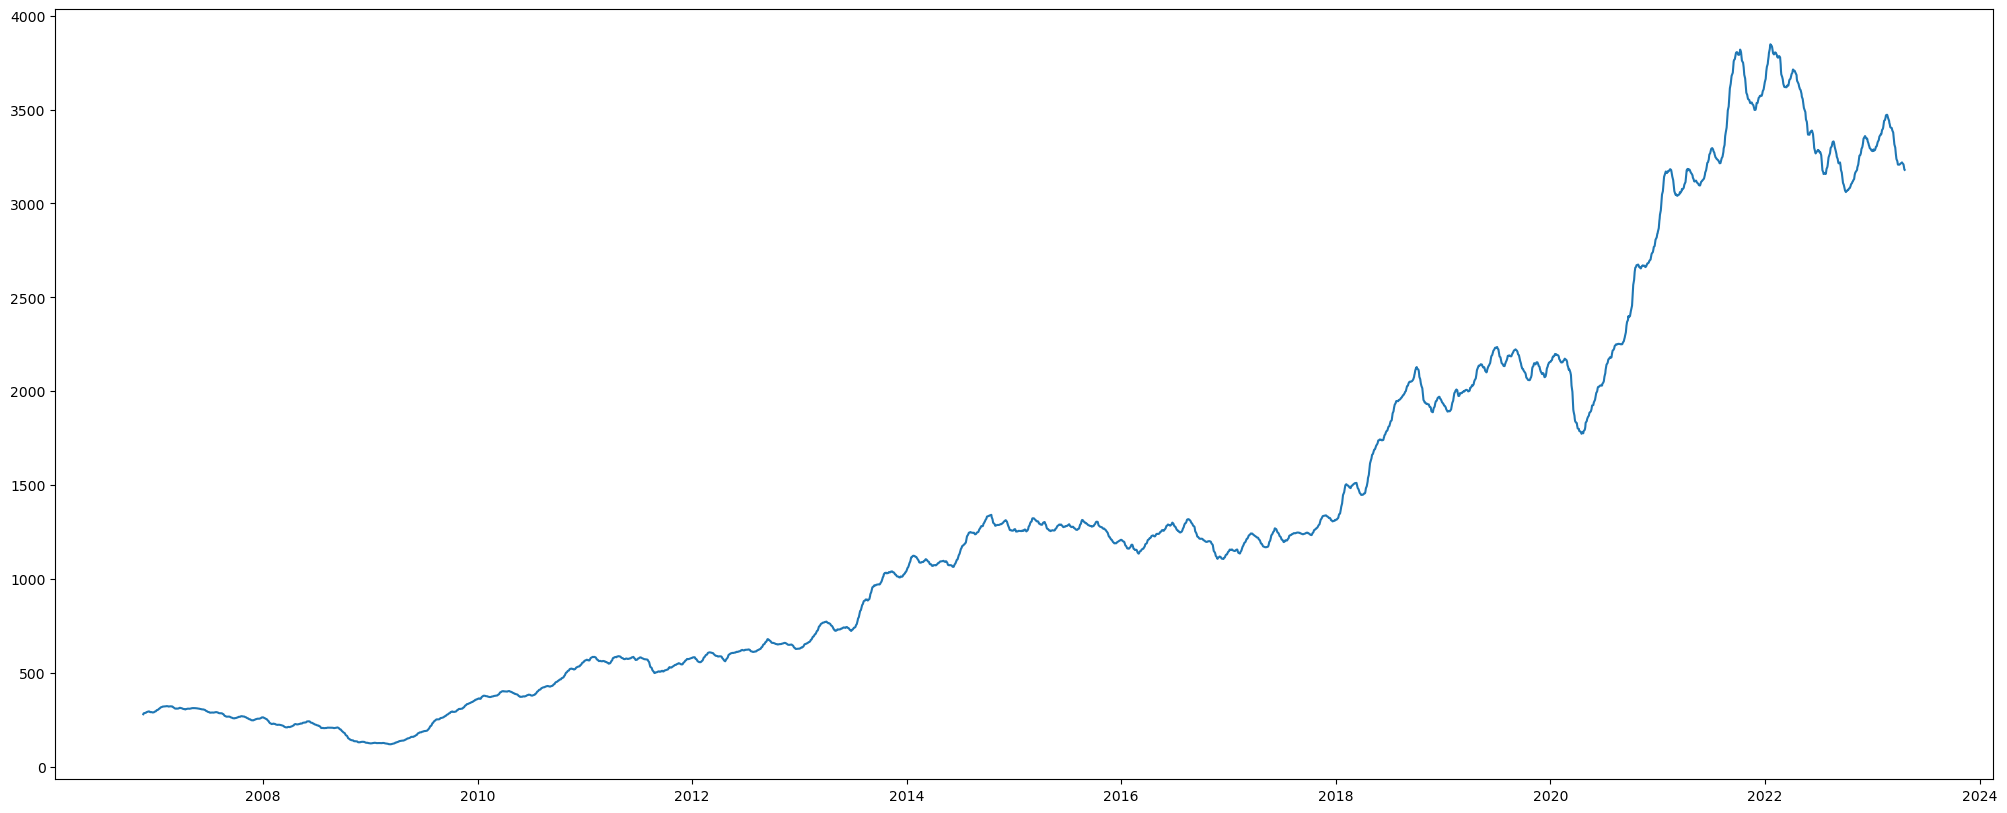

In [8]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more5
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.1)   # what should be this value

tmp1 = data.iloc[-6000:]       # 6000 is the number of days for which i have taken data 
plt.figure(figsize=(25,10))
plt.plot(tmp1['close'])

In [ ]:
# add more featues
#df['H-L'] = df['High'] - df['Low']
#df['O-C'] = df['Adj Close'] - df['Open']
#df['3day MA'] = df['Adj Close'].shift(1).rolling(window=3).mean()
#df['10day MA'] = df['Adj Close'].shift(1).rolling(window=10).mean()
#df['30day MA'] = df['Adj Close'].shift(1).rolling(window=30).mean()
#df['Std_dev'] = df['Adj Close'].rolling(5).std()

In [9]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    #del (data['open'])
    #del (data['high'])
    #del (data['low'])
    #del (data['volume'])
    #del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)
data = data.dropna()
#data.isnull().sum()  # what to do of these null values
data.head(10) # some columns are under ... how to resolve that

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', '14 period RSI',
       'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')


,open,high,low,close,Adj Close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-08,294.388072,298.165090,290.526603,294.257666,215.959048,3.184983e+06,99.944686,1.345382,0.933599,84.618004,...,4.872446e+07,110.042844,3.239109,0.845228,1.208542,1.018872,1.017204,1.015846,1.010015,0.872063
2006-12-11,294.309752,298.052768,289.664124,294.147787,215.878403,3.319321e+06,98.573462,1.386666,1.026837,81.153467,...,4.540514e+07,94.517707,2.220396,0.878090,1.150138,1.017133,1.015345,1.013903,1.007926,0.923680
2006-12-12,294.092555,297.686389,288.054226,292.464841,214.643270,3.535226e+06,80.382615,1.296794,1.082072,69.912811,...,4.186991e+07,71.292963,1.483067,0.908169,1.100386,1.010530,1.008735,1.007314,1.001782,0.986557
2006-12-13,292.449130,296.223122,285.940257,291.023228,213.585258,3.544873e+06,68.689131,1.121153,1.090031,59.807622,...,3.832504e+07,44.502951,0.831939,0.934454,1.059872,1.005184,1.003461,1.002128,0.997389,0.991095
2006-12-14,290.577660,295.503615,284.821332,290.604315,213.277811,3.472167e+06,65.698280,0.945662,1.060735,55.638703,...,3.485287e+07,32.186023,0.540251,0.942730,1.038690,1.003502,1.001860,1.000623,0.996647,0.975674
2006-12-15,290.750965,295.116147,285.069353,290.541211,213.231493,3.339378e+06,65.237464,0.794877,1.006944,55.268448,...,3.151350e+07,30.482185,0.395364,0.951037,1.026997,1.003087,1.001519,1.000369,0.997040,0.948364
2006-12-18,290.526284,295.338907,284.612420,291.076961,213.624683,3.228444e+06,67.332422,0.704295,0.945850,55.486832,...,3.474194e+07,24.012833,0.434926,0.949585,1.029217,1.004651,1.003119,1.002021,0.999069,0.930033
2006-12-19,291.050255,295.406693,284.239449,290.454185,213.167618,3.272279e+06,62.609019,0.584000,0.872942,46.497600,...,3.146966e+07,9.762130,0.273928,0.954619,1.016235,1.002362,1.000904,0.999887,0.997451,0.951926
2006-12-20,290.660703,295.028779,283.638493,289.547124,212.501922,3.325318e+06,56.402883,0.422158,0.782250,40.674570,...,2.814434e+07,-14.667882,-0.085230,0.973590,0.999096,0.999273,0.997932,0.997035,0.995290,0.972729


In [10]:
 # data.info()

In [11]:
# data.to_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file2.csv') # saving the dataframe

In [12]:
#fig,ax=plt.subplots(figsize=(10,6))
#sns.heatmap(data.corr(),center=0,cmap="Blues")
#ax.set_title('Multi-collinearity of stock market attributes')

<Axes: >

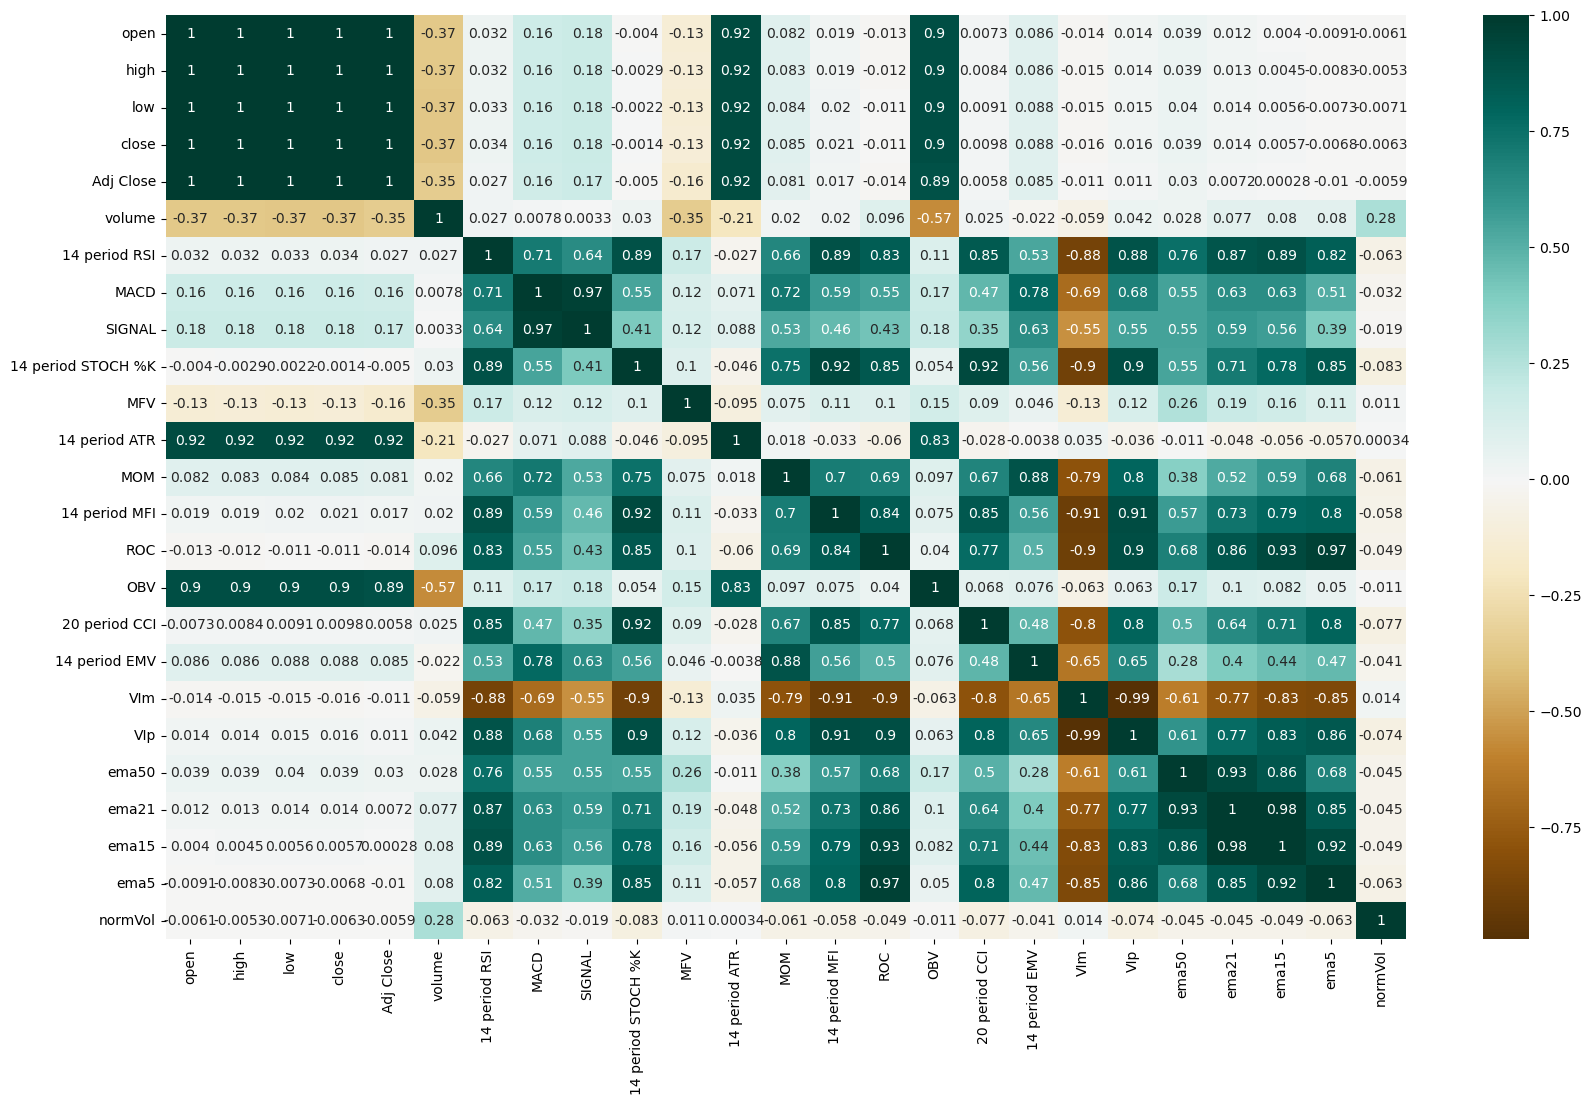

In [13]:
fig,ax=plt.subplots(figsize=(20,12))
sns.heatmap(data.corr(),center=0,cmap='BrBG',annot=True)

In [14]:
#del (data['open'])
#del (data['high'])
#del (data['low'])
#del (data['volume'])
#del (data['Adj Close'])
#del (data['20 period CCI'])


In [15]:
#fig,ax=plt.subplots(figsize=(20,12))
#sns.heatmap(data.corr(),center=0,cmap='BrBG',annot=True)

In [16]:
# data.info()


In [17]:
#variables=['open','high','low','close','ADJ Close','volume','14 period RSI','MACD','SIGNAL','14 period STOCH %K','MFV','14 period ATR','MOM','14 perid MFI','ROC','OBV','20 period CCI','14 period EMV','VIm','VIp','ema50','ema21','ema15','ema5','normVol']
#x=data.loc[:variables].values
#y=data.loc[:['target']].values
#x=StandardScaler().fit_transform(x)
#x=pd.DataFrame(x)

In [18]:
#standardizing the features
scalar=StandardScaler()
scaled_data=pd.DataFrame(scalar.fit_transform(data))
scaled_data

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.013872,-1.015198,-1.012556,-1.013972,-0.977483,-0.056783,1.337304,-0.181781,-0.212298,1.117066,...,-1.433900,0.704281,-0.047248,-1.162503,1.675754,-0.130716,0.103202,0.222997,0.466862,-1.199074
1,-1.013948,-1.015306,-1.013400,-1.014078,-0.977562,0.033388,1.292674,-0.179824,-0.207682,0.986603,...,-1.438300,0.579197,-0.058481,-0.862111,1.135975,-0.151537,0.062217,0.165319,0.328842,-0.708651
2,-1.014158,-1.015658,-1.014977,-1.015712,-0.978770,0.178310,0.700608,-0.184085,-0.204947,0.563318,...,-1.442987,0.392077,-0.066611,-0.587163,0.676161,-0.230626,-0.083499,-0.030230,-0.077170,-0.111255
3,-1.015753,-1.017065,-1.017048,-1.017111,-0.979805,0.184786,0.320014,-0.192412,-0.204553,0.182790,...,-1.447687,0.176232,-0.073791,-0.346899,0.301717,-0.294649,-0.199797,-0.184141,-0.367444,-0.068146
4,-1.017568,-1.017757,-1.018144,-1.017518,-0.980106,0.135983,0.222670,-0.200733,-0.206004,0.025803,...,-1.452290,0.076996,-0.077008,-0.271244,0.105956,-0.314786,-0.235092,-0.228811,-0.416458,-0.214656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,1.815644,1.812979,1.814465,1.814033,1.948637,-0.474020,-1.393973,-2.198138,-2.446512,-1.009755,...,1.430877,-0.723075,-1.569769,0.968621,-0.983269,-0.722513,-0.862681,-0.845756,-0.505599,2.226830
4031,1.810187,1.805120,1.807984,1.806566,1.941124,-0.470401,-1.434845,-2.150254,-2.406719,-0.997410,...,1.427472,-0.813346,-1.360576,0.884641,-0.898642,-0.742888,-0.885949,-0.871887,-0.585716,1.808697
4032,1.802928,1.796425,1.798321,1.795851,1.930338,-0.421451,-1.486769,-2.132782,-2.371236,-1.015896,...,1.423969,-0.983591,-1.243122,0.854370,-0.872376,-0.774804,-0.929737,-0.924892,-0.710211,1.714241
4033,1.792442,1.786003,1.790261,1.787684,1.922117,-0.436332,-1.521695,-2.129412,-2.342145,-0.990185,...,1.420497,-1.200610,-1.129252,0.838981,-0.842272,-0.796831,-0.954905,-0.952336,-0.769491,1.316386


In [19]:
#fig,ax=plt.subplots(figsize=(20,12))
#sns.heatmap(scaled_data.corr(),center=0,cmap='BrBG',annot=True)

In [20]:
pca=PCA(n_components=5)
pca.fit(data)
data_pca=pca.transform(data)
data_pca=pd.DataFrame(data_pca,columns=['pc1','pc2','pc3','pc4','pc5'])
data_pca.head()

,pc1,pc2,pc3,pc4,pc5
0,1.081037e+09,8.621831e+07,-249647.143928,2329.788438,-108.400060
1,1.084355e+09,8.646756e+07,-115993.083452,2318.211388,-91.339615
2,1.087893e+09,8.619068e+07,92568.310923,2281.649188,-62.576932
3,1.091438e+09,8.617368e+07,98018.640541,2287.243761,-35.651786
4,1.094908e+09,8.648471e+07,25195.023084,2314.741103,-23.958747


<Axes: >

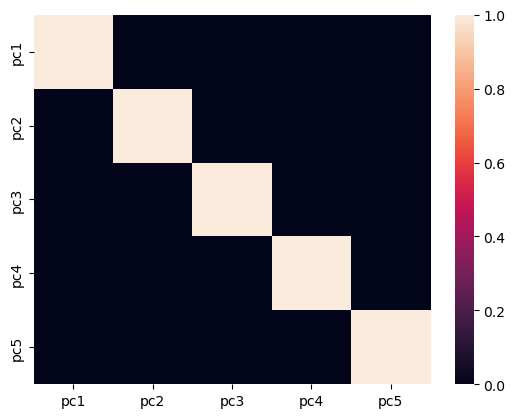

In [21]:
sns.heatmap(data_pca.corr())

In [22]:
live_pred_data = data.iloc[-10:]  #data of last 10 days from today
live_pred_data.head(10)

,open,high,low,close,Adj Close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-06,3214.651131,3241.572455,3185.119076,3210.484301,3210.284795,1.906213e+06,11.678363,-50.592242,-44.565217,15.290949,...,2.212431e+09,-80.930537,-311.867038,1.176857,0.831130,0.967437,0.968014,0.973413,0.992047,1.006022
2023-04-10,3215.186018,3244.615210,3188.107168,3215.775861,3215.596306,1.935910e+06,15.778282,-48.841177,-45.420409,19.621342,...,2.214367e+09,-71.129423,-264.286039,1.153826,0.852293,0.969620,0.970951,0.976644,0.994729,1.018014
2023-04-11,3220.067416,3247.448684,3188.511441,3215.578280,3215.416680,1.977197e+06,15.748885,-46.928427,-45.722013,21.838743,...,2.212389e+09,-64.869326,-228.669635,1.132880,0.872242,0.970140,0.972177,0.978111,0.995553,1.032887
2023-04-12,3220.855670,3248.798811,3189.560297,3218.185442,3218.040003,2.021250e+06,17.921980,-44.687058,-45.515022,26.580366,...,2.214411e+09,-58.216374,-186.384312,1.109153,0.897034,0.971480,0.974163,0.980283,0.996965,1.046153
2023-04-13,3219.770103,3246.918930,3188.604268,3215.251908,3215.121012,2.236532e+06,17.378816,-42.655760,-44.943169,28.031697,...,2.212174e+09,-56.700545,-151.744435,1.089871,0.916881,0.971154,0.974458,0.980737,0.996711,1.127955
2023-04-17,3211.203102,3238.567027,3176.768841,3207.676717,3207.558911,2.563384e+06,16.027956,-41.182470,-44.191030,28.138705,...,2.209611e+09,-67.116474,-134.836913,1.078369,0.920836,0.969458,0.973394,0.979835,0.995298,1.232644
2023-04-18,3205.577787,3230.395334,3170.151967,3199.984045,3199.878020,2.568776e+06,14.772204,-40.172528,-43.387329,28.466533,...,2.207042e+09,-78.320615,-115.865444,1.069182,0.929993,0.967757,0.972339,0.978955,0.994086,1.188635
2023-04-19,3198.095008,3221.355801,3160.286770,3188.945651,3188.850228,2.641701e+06,13.176871,-39.804011,-42.670666,27.975627,...,2.204400e+09,-99.450991,-105.213629,1.065870,0.932835,0.965092,0.970353,0.977169,0.992202,1.178694
2023-04-20,3187.285508,3210.520220,3152.058093,3180.531090,3180.445210,2.619531e+06,12.103778,-39.732928,-42.083118,28.658391,...,2.201781e+09,-126.386791,-94.886815,1.064187,0.936092,0.963253,0.969211,0.976244,0.991304,1.136819


In [23]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=1)
#data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
print(len(data))
data.head(10)

4035


,open,high,low,close,Adj Close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-08,294.388072,298.165090,290.526603,294.257666,215.959048,3.184983e+06,99.944686,1.345382,0.933599,84.618004,...,110.042844,3.239109,0.845228,1.208542,1.018872,1.017204,1.015846,1.010015,0.872063,0.0
2006-12-11,294.309752,298.052768,289.664124,294.147787,215.878403,3.319321e+06,98.573462,1.386666,1.026837,81.153467,...,94.517707,2.220396,0.878090,1.150138,1.017133,1.015345,1.013903,1.007926,0.923680,0.0
2006-12-12,294.092555,297.686389,288.054226,292.464841,214.643270,3.535226e+06,80.382615,1.296794,1.082072,69.912811,...,71.292963,1.483067,0.908169,1.100386,1.010530,1.008735,1.007314,1.001782,0.986557,0.0
2006-12-13,292.449130,296.223122,285.940257,291.023228,213.585258,3.544873e+06,68.689131,1.121153,1.090031,59.807622,...,44.502951,0.831939,0.934454,1.059872,1.005184,1.003461,1.002128,0.997389,0.991095,0.0
2006-12-14,290.577660,295.503615,284.821332,290.604315,213.277811,3.472167e+06,65.698280,0.945662,1.060735,55.638703,...,32.186023,0.540251,0.942730,1.038690,1.003502,1.001860,1.000623,0.996647,0.975674,0.0
2006-12-15,290.750965,295.116147,285.069353,290.541211,213.231493,3.339378e+06,65.237464,0.794877,1.006944,55.268448,...,30.482185,0.395364,0.951037,1.026997,1.003087,1.001519,1.000369,0.997040,0.948364,1.0
2006-12-18,290.526284,295.338907,284.612420,291.076961,213.624683,3.228444e+06,67.332422,0.704295,0.945850,55.486832,...,24.012833,0.434926,0.949585,1.029217,1.004651,1.003119,1.002021,0.999069,0.930033,0.0
2006-12-19,291.050255,295.406693,284.239449,290.454185,213.167618,3.272279e+06,62.609019,0.584000,0.872942,46.497600,...,9.762130,0.273928,0.954619,1.016235,1.002362,1.000904,0.999887,0.997451,0.951926,0.0
2006-12-20,290.660703,295.028779,283.638493,289.547124,212.501922,3.325318e+06,56.402883,0.422158,0.782250,40.674570,...,-14.667882,-0.085230,0.973590,0.999096,0.999273,0.997932,0.997035,0.995290,0.972729,0.0


In [24]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    
    # Create a tuple list of our models
    estimators=[('knn', knn), ('rf', rf)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)
        
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
#         print('rf prediction is ', rf_prediction)
#         print('knn prediction is ', knn_prediction)
#         print('ensemble prediction is ', ensemble_prediction)
#         print('truth values are ', y_test.values)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
#         print(rf_accuracy)
#         print(knn_accuracy)
#         print(ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
cross_Validation(data)

RF Accuracy = 0.5556250000000005
KNN Accuracy = 0.48458333333333364
ENSEMBLE Accuracy = 0.501041666666667
